<a href="https://colab.research.google.com/github/bilmark0/Deep-Learning-alpjai-Main-Project/blob/main/mtdk_postproc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


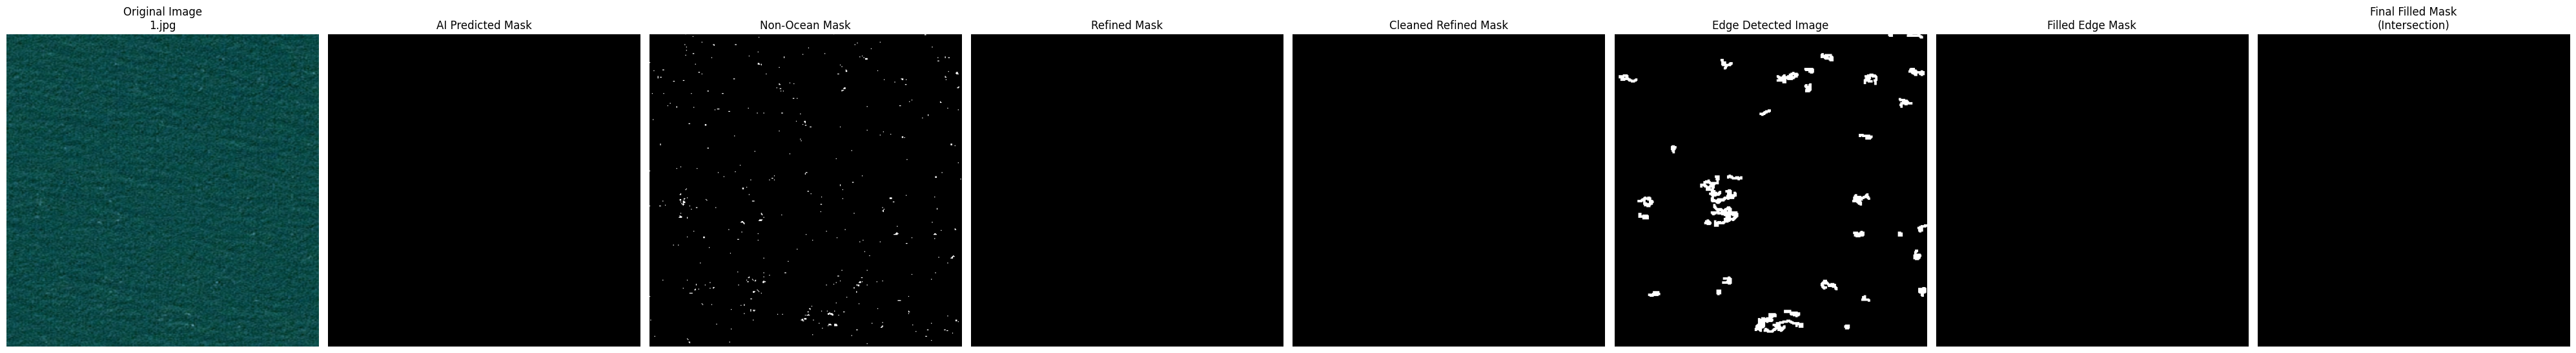

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


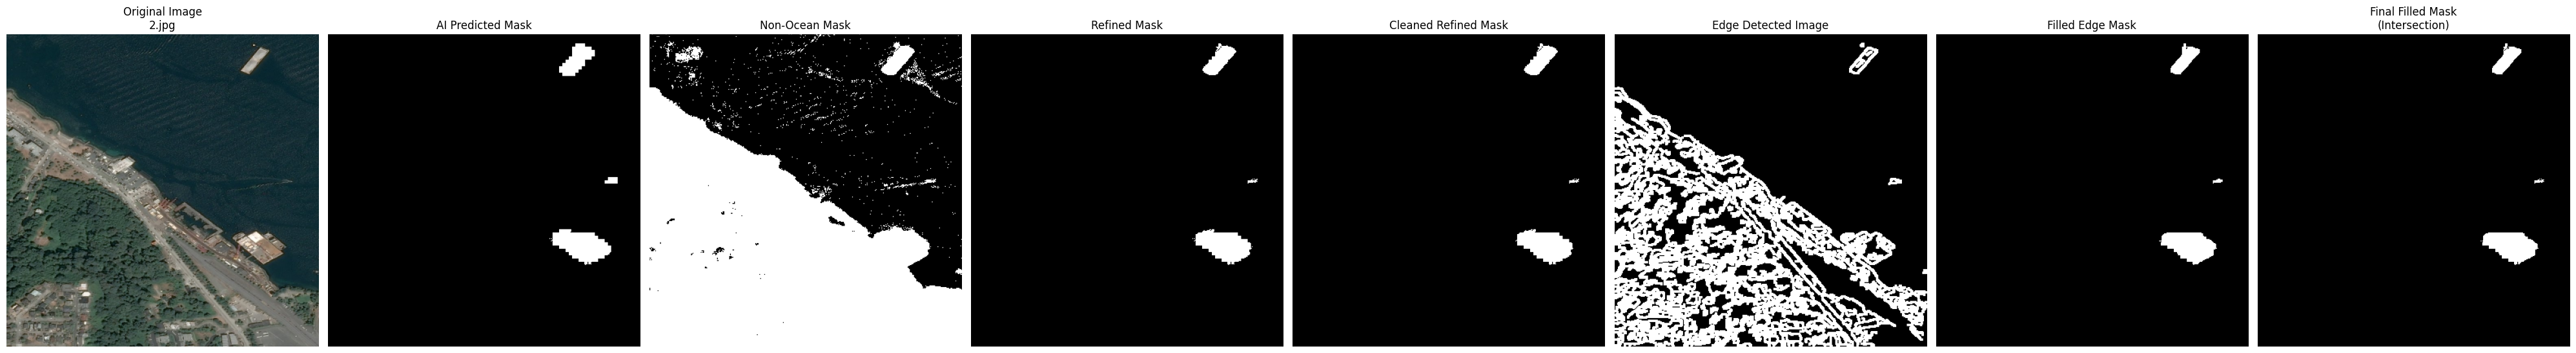

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


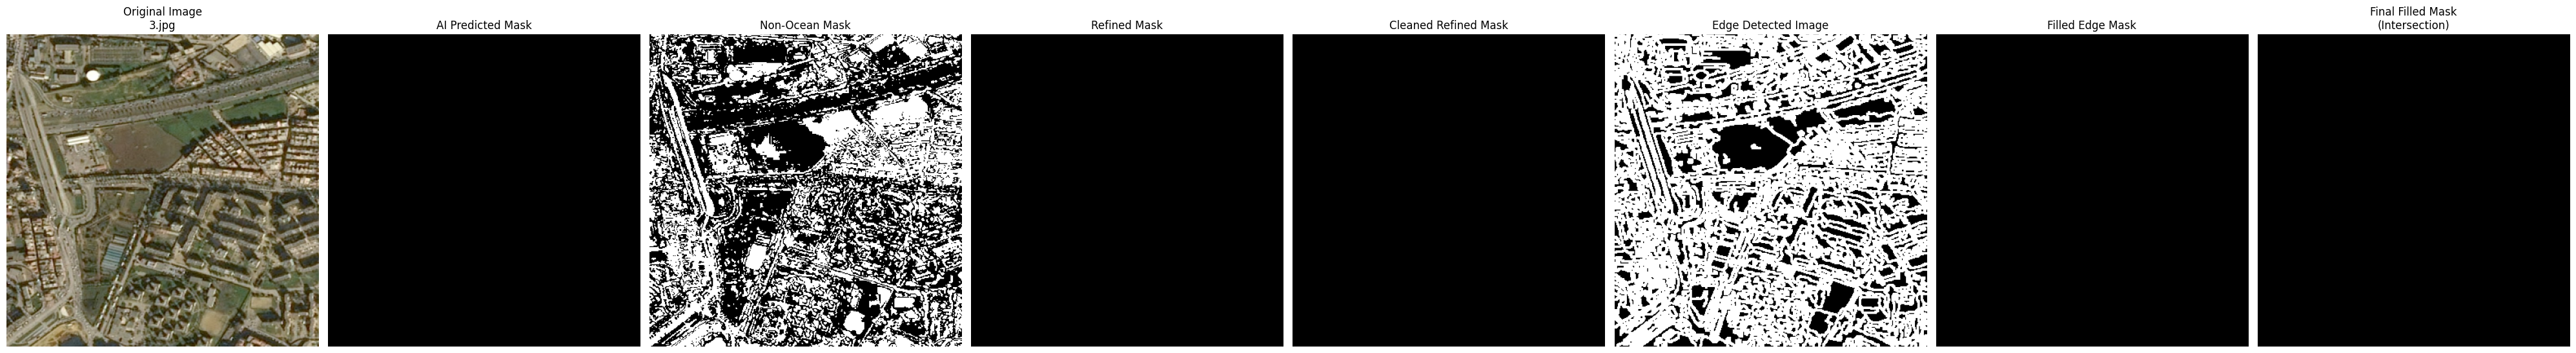

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


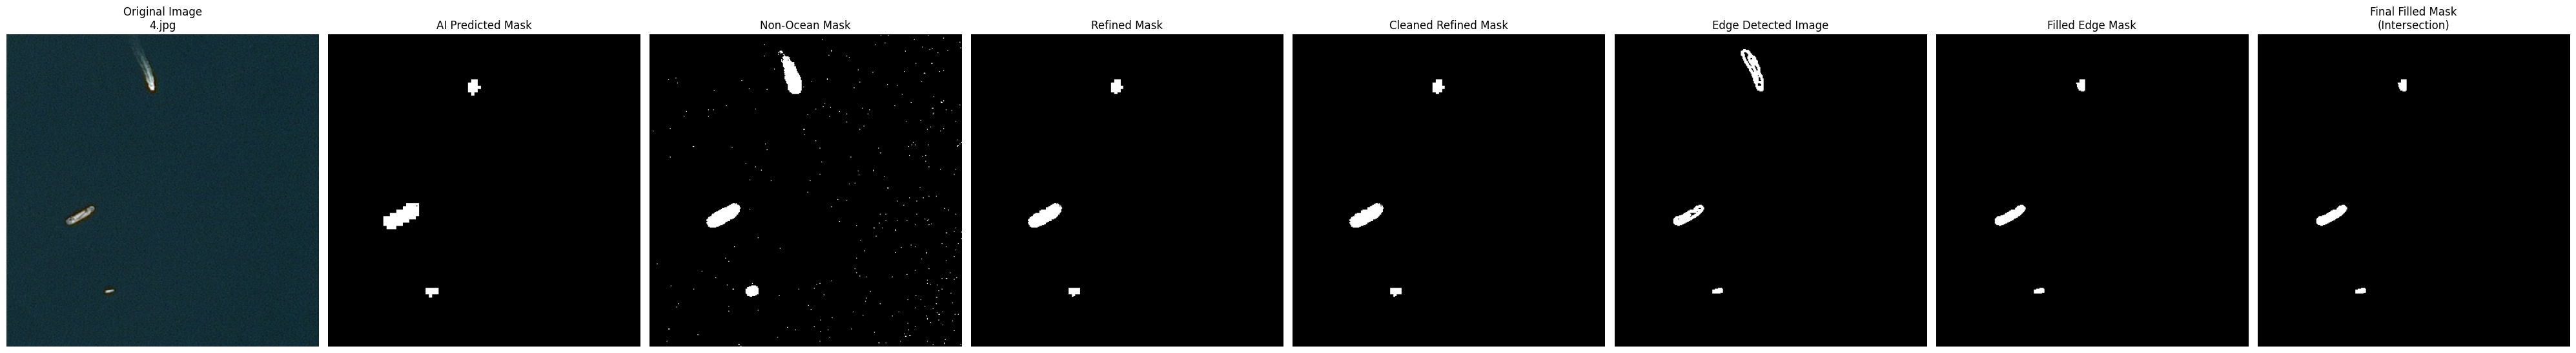

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


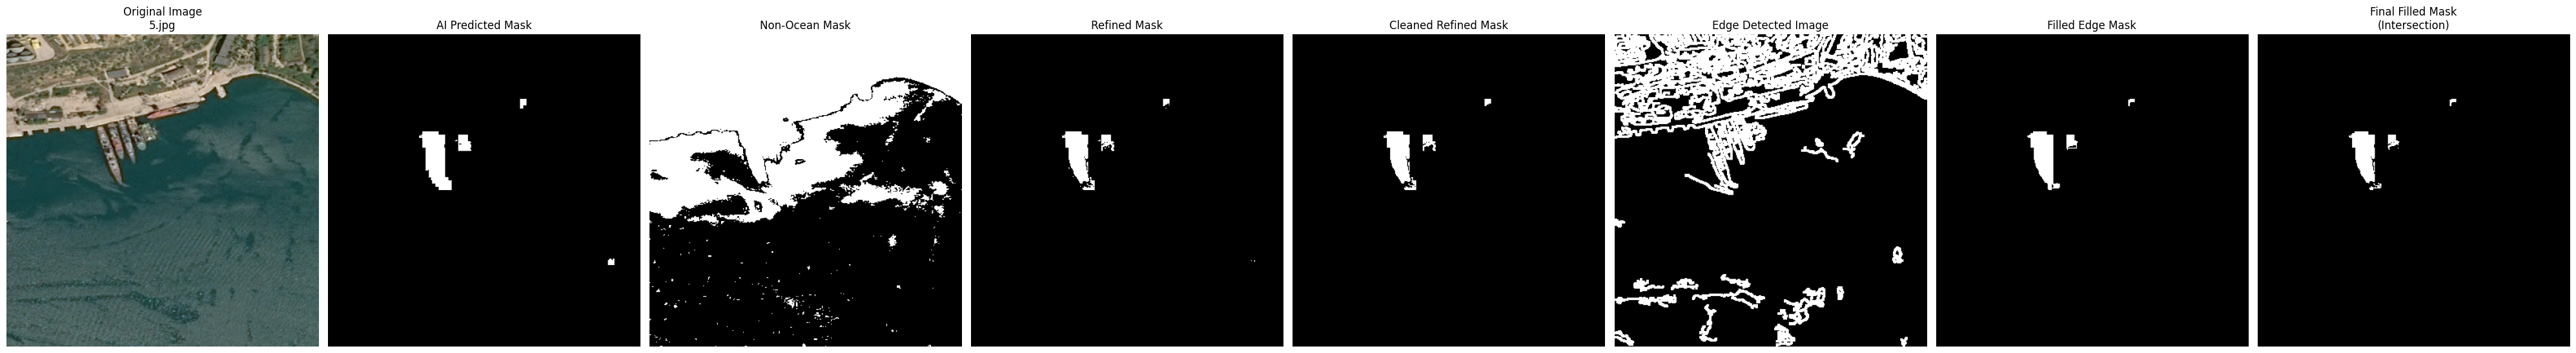

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


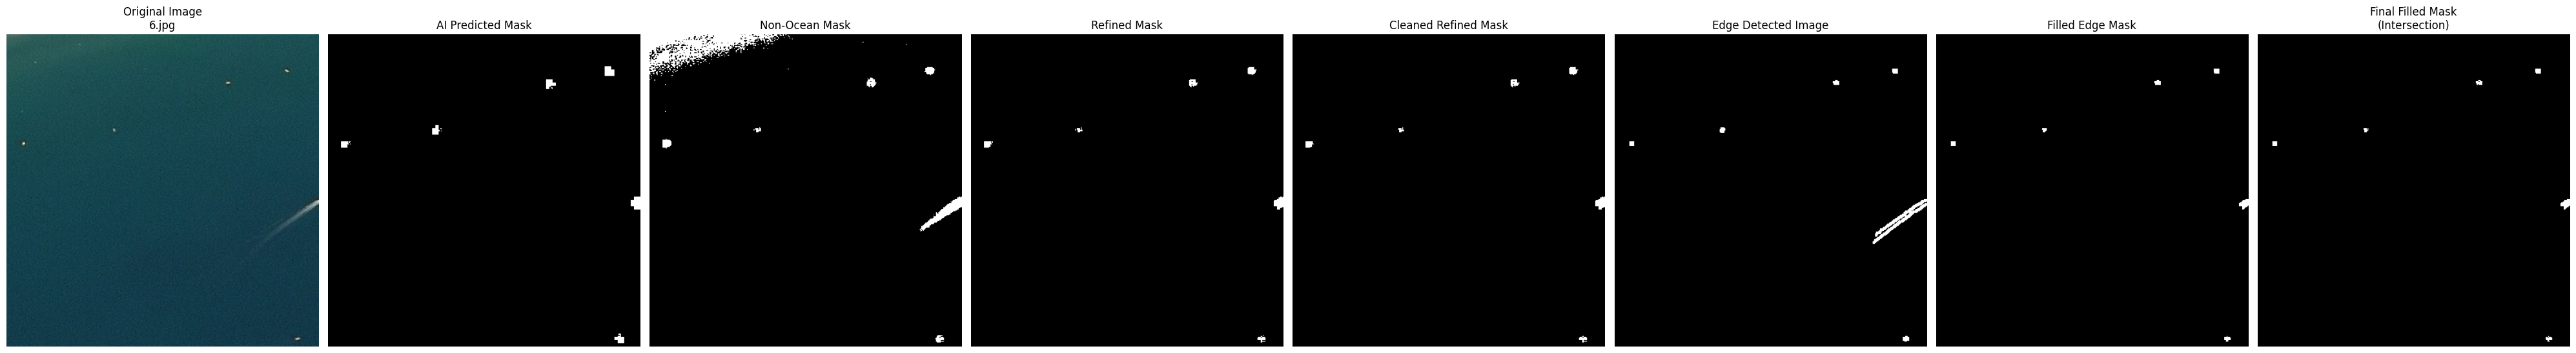

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


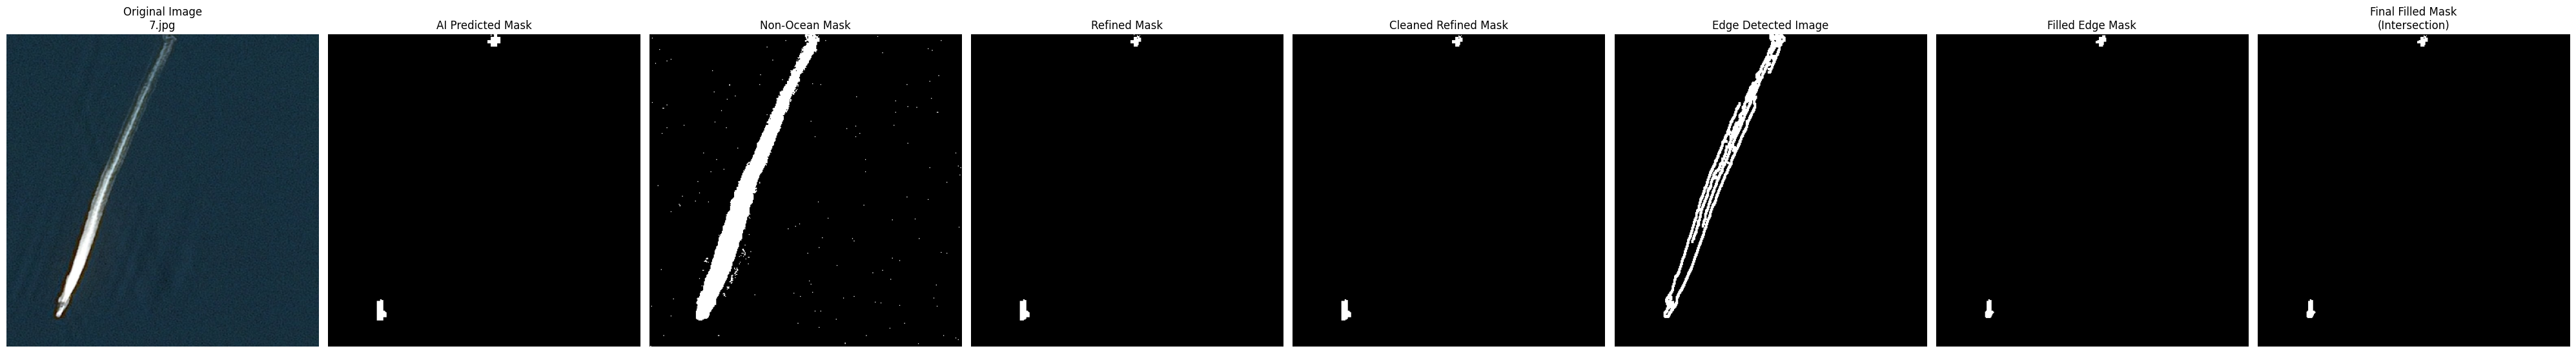

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


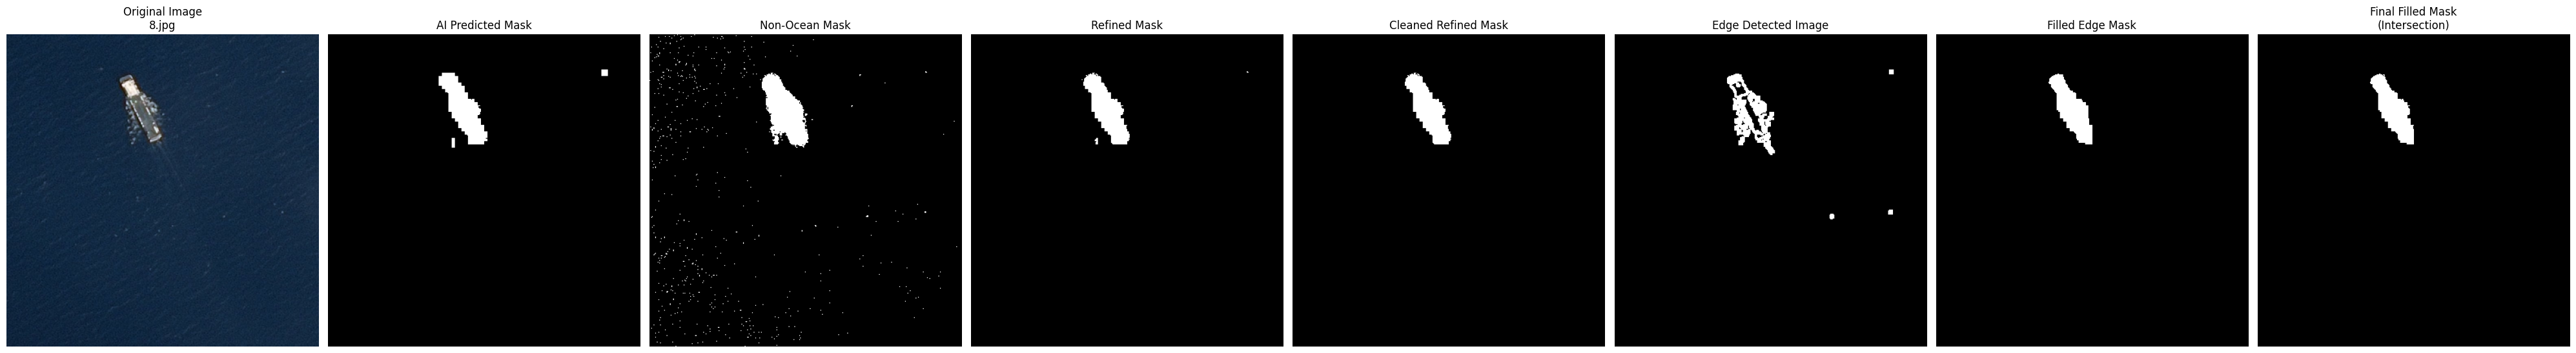

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


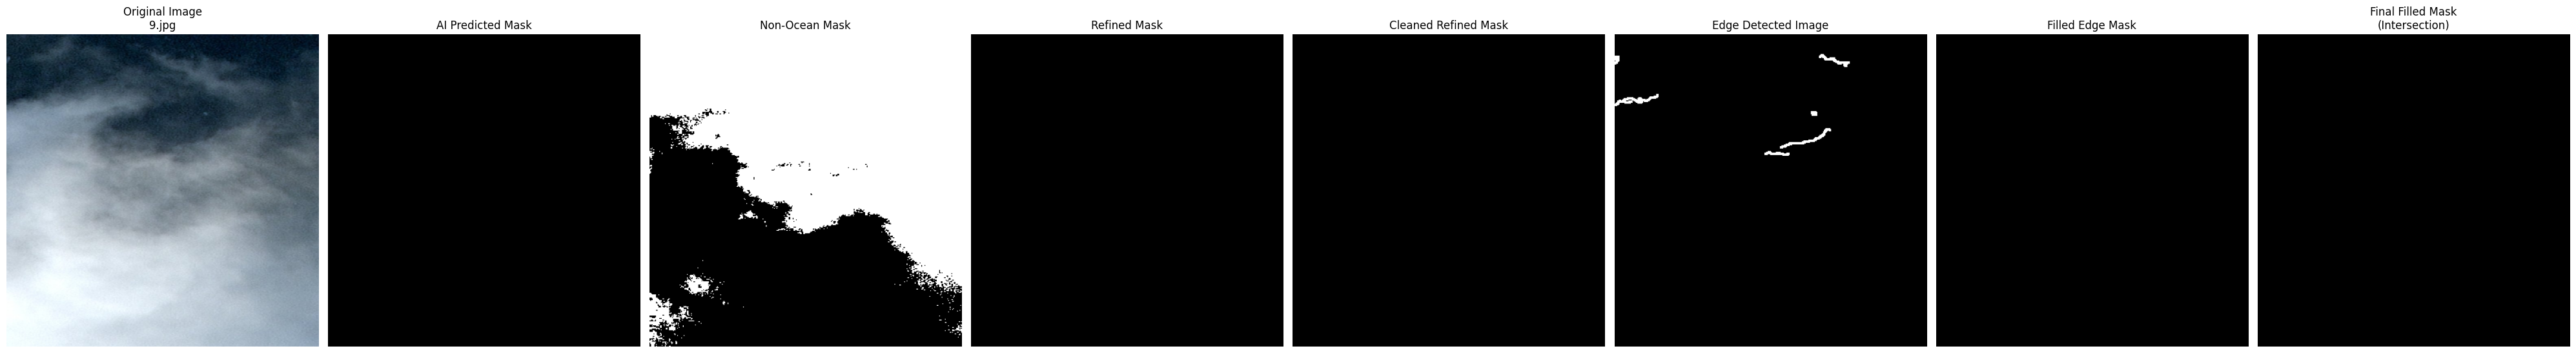

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


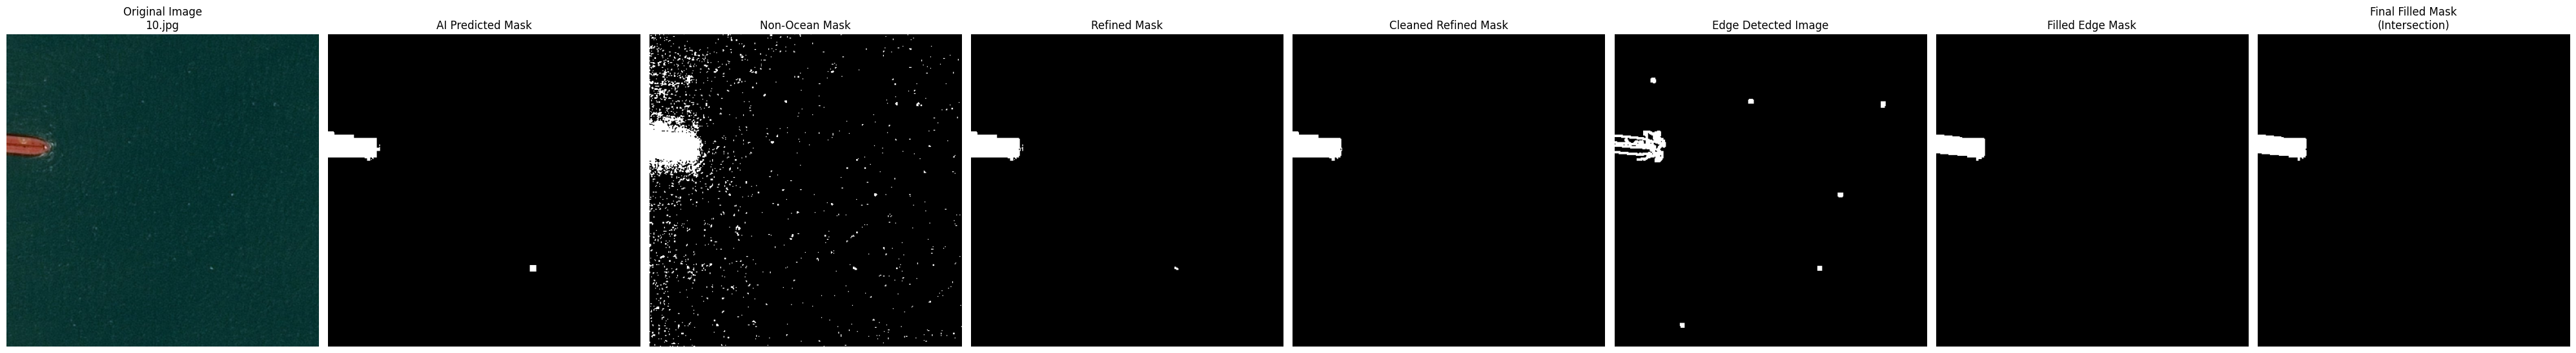

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


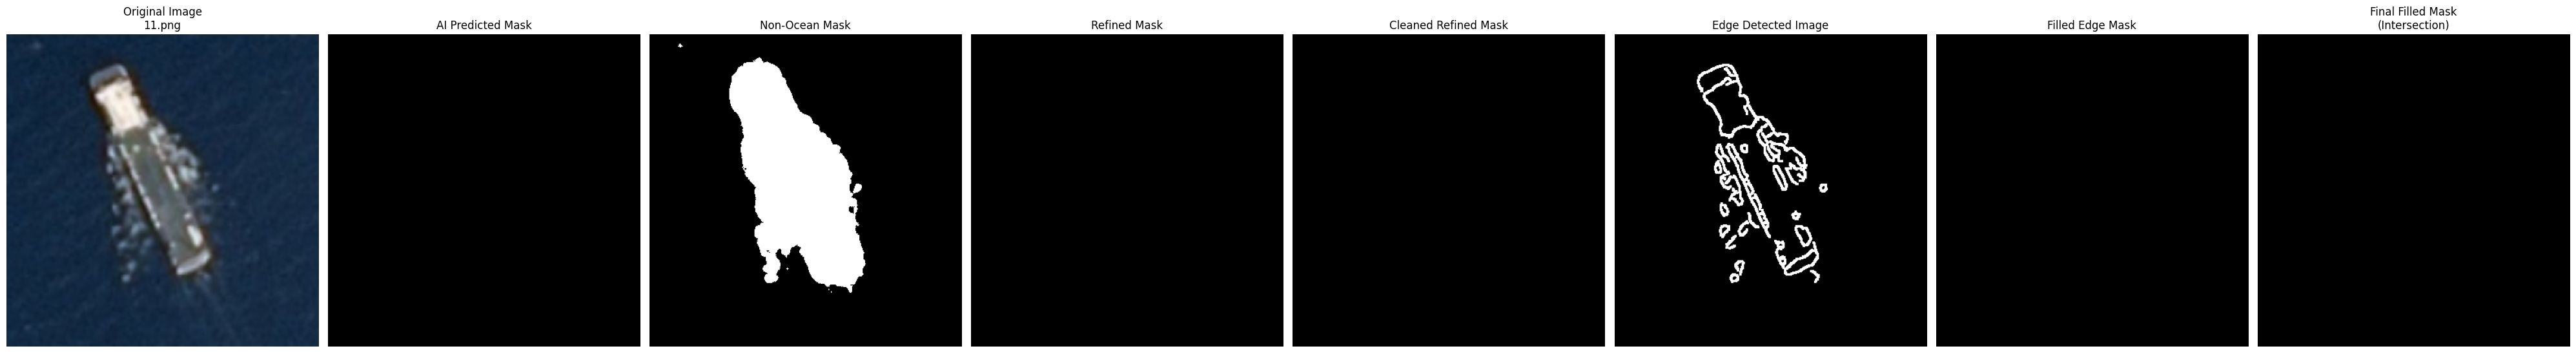

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


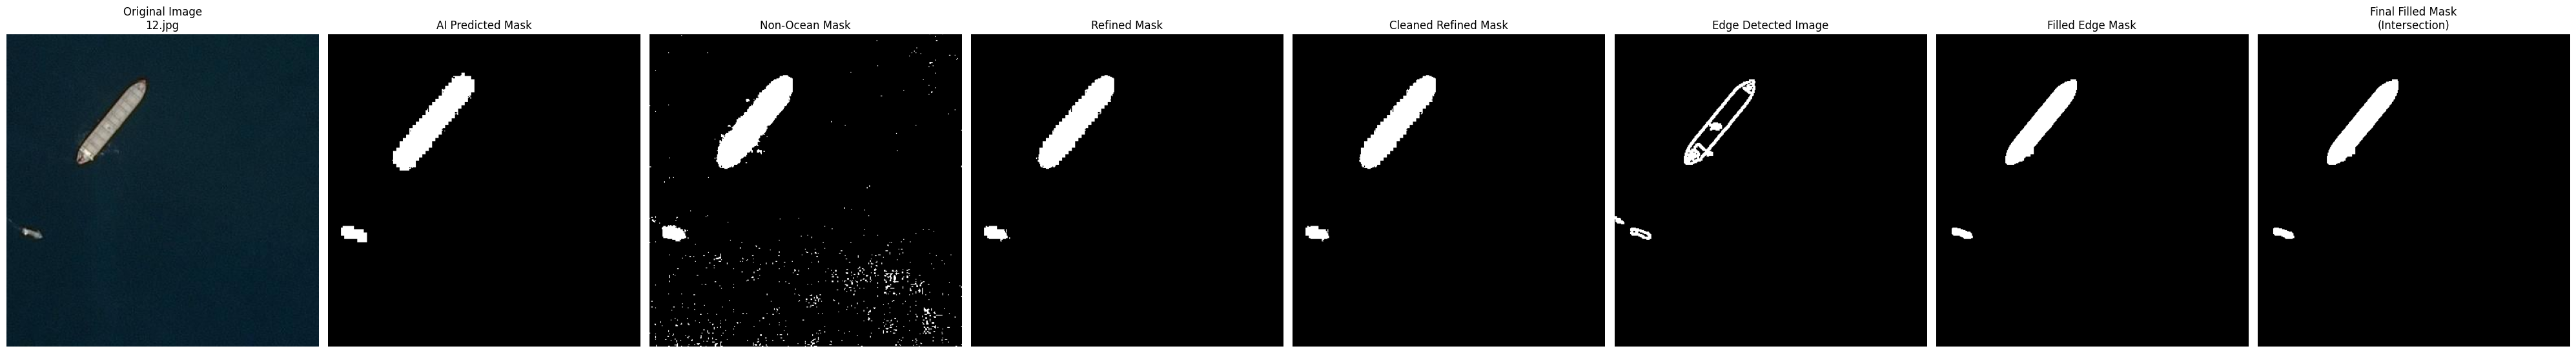

In [ ]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the saved model
model = tf.keras.models.load_model('mask_rcnn_best_model.keras')

# List of image file names
image_names = [
    "1.jpg", "2.jpg", "3.jpg", "4.jpg", "5.jpg",
    "6.jpg", "7.jpg", "8.jpg", "9.jpg", "10.jpg", "11.png","12.jpg"
]

# Path to the folder containing test images (if applicable)
image_folder = ''


def get_dominant_color_kmeans(image_hsv, k=3, sample_pixels=10000):
    """
    Compute the dominant HSV color of an image using k-means clustering.
    """
    pixels = image_hsv.reshape(-1, 3)
    if pixels.shape[0] > sample_pixels:
        idx = np.random.choice(pixels.shape[0], sample_pixels, replace=False)
        pixels = pixels[idx]
    pixels = np.float32(pixels)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    _, labels, centers = cv2.kmeans(pixels, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    labels = labels.flatten()
    counts = np.bincount(labels)
    dominant = centers[np.argmax(counts)]
    dominant = dominant.astype(np.uint8)
    return dominant


def ocean_removal_mask(image, tolerance=np.array([10, 50, 50])):
    """
    Create a binary mask for non-ocean areas based on the dominant HSV color.
    Pixels similar to the dominant (ocean) color are removed.
    """
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    dominant = get_dominant_color_kmeans(hsv, k=3)
    lower_bound = np.clip(dominant - tolerance, [0, 0, 0], [179, 255, 255])
    upper_bound = np.clip(dominant + tolerance, [0, 0, 0], [179, 255, 255])
    ocean_mask = cv2.inRange(hsv, lower_bound, upper_bound)
    non_ocean_mask = cv2.bitwise_not(ocean_mask)
    # Convert mask to binary (0 or 1)
    non_ocean_mask = (non_ocean_mask > 0).astype(np.uint8)
    return non_ocean_mask


def refine_mask_with_ocean(pred_mask, non_ocean_mask):
    """
    Refine the AI model's predicted mask by intersecting it with the non-ocean mask.
    """
    refined_mask = cv2.bitwise_and(pred_mask, non_ocean_mask)
    return refined_mask


def remove_small_spots(mask, area_threshold_ratio=0.02):
    """
    Remove small connected components (spots) from a binary mask.
    Components smaller than a fraction of the largest component are removed.
    """
    mask_uint8 = (mask * 255).astype(np.uint8)
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask_uint8, connectivity=8)

    if num_labels <= 1:
        return mask

    areas = stats[1:, cv2.CC_STAT_AREA]
    max_area = areas.max()
    min_area = area_threshold_ratio * max_area

    cleaned_mask = np.zeros_like(mask, dtype=np.uint8)
    for label in range(1, num_labels):
        area = stats[label, cv2.CC_STAT_AREA]
        if area >= min_area:
            cleaned_mask[labels == label] = 1
    return cleaned_mask


# -------------------------------
# Edge filling functions
# -------------------------------

def fill_edges_horizontal(region):
    """
    For each row in the binary region mask, if there are at least two edge pixels,
    fill in (set to 1) all pixels between the leftmost and rightmost edge pixels.
    """
    filled = np.zeros_like(region)
    for i in range(region.shape[0]):
        edge_indices = np.where(region[i, :] > 0)[0]
        if edge_indices.size >= 2:
            left, right = edge_indices[0], edge_indices[-1]
            filled[i, left:right + 1] = 1
    return filled


def fill_edges_vertical(region):
    """
    For each column in the binary region mask, if there are at least two edge pixels,
    fill in (set to 1) all pixels between the topmost and bottommost edge pixels.
    """
    filled = np.zeros_like(region)
    for j in range(region.shape[1]):
        edge_indices = np.where(region[:, j] > 0)[0]
        if edge_indices.size >= 2:
            top, bottom = edge_indices[0], edge_indices[-1]
            filled[top:bottom + 1, j] = 1
    return filled


def fill_edges(region):
    """
    Combine horizontal and vertical filling on the region.
    A pixel is filled if it is filled in either pass.
    """
    horizontal_filled = fill_edges_horizontal(region)
    vertical_filled = fill_edges_vertical(region)
    combined = np.maximum(horizontal_filled, vertical_filled)
    return combined


# -------------------------------
# Main processing and visualization
# -------------------------------

def visualize_predictions(image_name):
    image_path = image_folder + image_name
    image = cv2.imread(image_path)
    if image is None:
        print(f"Could not load image: {image_name}")
        return

    # Resize image to match the model's expected input size (384x384)
    image_resized = cv2.resize(image, (384, 384))
    image_normalized = image_resized.astype(np.float32) / 255.0
    image_input = np.expand_dims(image_normalized, axis=0)

    # Generate prediction from the AI ship detection model
    predictions = model.predict(image_input)
    pred_mask = (predictions[0] > 0.25).astype(np.uint8)

    # Generate non-ocean mask based on dominant color analysis
    non_ocean_mask = ocean_removal_mask(image_resized)

    # Intersect predicted mask with non-ocean mask
    refined_mask = refine_mask_with_ocean(pred_mask, non_ocean_mask)

    # Remove small spots from the refined mask
    cleaned_refined_mask = remove_small_spots(refined_mask, area_threshold_ratio=0.02)

    # --------------------------------------------------
    # Edge detection on the original resized image
    # --------------------------------------------------
    gray = cv2.cvtColor(image_resized, cv2.COLOR_BGR2GRAY)
    blurred_gray = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred_gray, 30, 100)
    # Optionally, dilate to close gaps between edge segments
    kernel = np.ones((3, 3), np.uint8)
    edges = cv2.dilate(edges, kernel, iterations=1)
    # Convert edges to a binary mask (0 and 1)
    edge_binary = (edges > 0).astype(np.uint8)

    # --------------------------------------------------
    # Create a masked edge image that only keeps edges within the cleaned refined mask.
    # --------------------------------------------------
    masked_edge_image = cv2.bitwise_and(edge_binary, cleaned_refined_mask)

    # --------------------------------------------------
    # For each region in the cleaned refined mask, perform edge-based filling using the masked edges.
    # --------------------------------------------------
    filled_edge_mask = np.zeros_like(edge_binary)
    cleaned_uint8 = cleaned_refined_mask.astype(np.uint8)
    num_labels, labels = cv2.connectedComponents(cleaned_uint8)
    for label in range(1, num_labels):
        region_mask = np.zeros_like(cleaned_refined_mask, dtype=np.uint8)
        region_mask[labels == label] = 1

        # Get the bounding box for the current region using contours
        contours, _ = cv2.findContours(region_mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if len(contours) == 0:
            continue
        for cnt in contours:
            x, y, w, h = cv2.boundingRect(cnt)
            # Extract the sub-region from the masked edge image (now only containing edges within the cleaned region)
            sub_region_edges = masked_edge_image[y:y+h, x:x+w]
            # Apply the combined filling passes on the sub-region edges
            filled_subregion = fill_edges(sub_region_edges)
            # Merge the filled sub-region back into the overall filled edge mask
            filled_edge_mask[y:y+h, x:x+w] = np.maximum(
                filled_edge_mask[y:y+h, x:x+w],
                filled_subregion
            )

    # --------------------------------------------------
    # Final intersection: Take the intersection of the filled edge mask and the cleaned refined mask.
    # --------------------------------------------------
    final_filled_mask = cv2.bitwise_and(filled_edge_mask, cleaned_refined_mask)

    # --------------------------------------------------
    # Visualization: show all processing stages
    # --------------------------------------------------
    fig, axes = plt.subplots(1, 8, figsize=(40, 6))

    axes[0].imshow(cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB))
    axes[0].set_title(f"Original Image\n{image_name}")
    axes[0].axis('off')

    axes[1].imshow(pred_mask, cmap='gray')
    axes[1].set_title("AI Predicted Mask")
    axes[1].axis('off')

    axes[2].imshow(non_ocean_mask, cmap='gray')
    axes[2].set_title("Non-Ocean Mask")
    axes[2].axis('off')

    axes[3].imshow(refined_mask, cmap='gray')
    axes[3].set_title("Refined Mask")
    axes[3].axis('off')

    axes[4].imshow(cleaned_refined_mask, cmap='gray')
    axes[4].set_title("Cleaned Refined Mask")
    axes[4].axis('off')

    axes[5].imshow(edges, cmap='gray')
    axes[5].set_title("Edge Detected Image")
    axes[5].axis('off')

    axes[6].imshow(filled_edge_mask, cmap='gray')
    axes[6].set_title("Filled Edge Mask")
    axes[6].axis('off')

    axes[7].imshow(final_filled_mask, cmap='gray')
    axes[7].set_title("Final Filled Mask\n(Intersection)")
    axes[7].axis('off')

    plt.tight_layout()
    plt.show()


# Process and visualize each image in the list
for image_name in image_names:
    visualize_predictions(image_name)
